# Superdense Coding

このノートブックは、Superdense Coding(SDC)プロトコルを示しています。最初にQiskitのシミュレーターを使用して量子回路をテストし、次に実際の量子コンピュータで試してみます。

## 1. The Difference between Superdense Coding and Quantum Teleportation

量子テレポーテーションと"superdense coding(超高密度コーディング)"は密接に関連しており、混乱を避けるために違いを明確にする必要があります。

量子テレポーテーションは、2bitの古典的な通信とベルペアを使用して、qubitの状態(|ψ>)をある場所から別の場所に送信できるプロセスです。言い換えれば、共有エンタングルメントの助けを借りて、1つの場所のqubitの量子状態を破壊し、遠い場所のqubitでそれを再作成するプロトコルと言えます。超高密度コーディングは、誰かが単一のqubitの通信を使用して、2つの古典的なbitを別の当事者に送信できるようにする手順です。

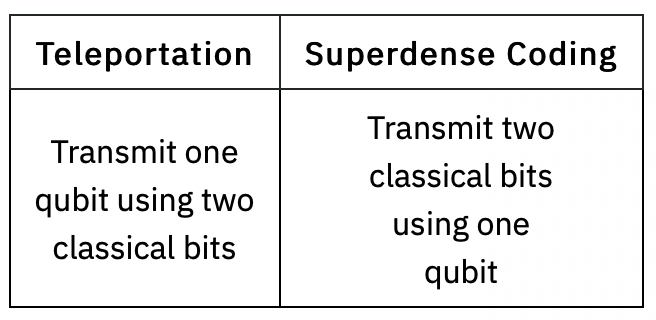

テレポーテーションプロトコルは、アリスとボブが単に「機器を交換する」という意味で、超高密度コーディングプロトコルの反転バージョンと考えることができます。

## 2. The Process

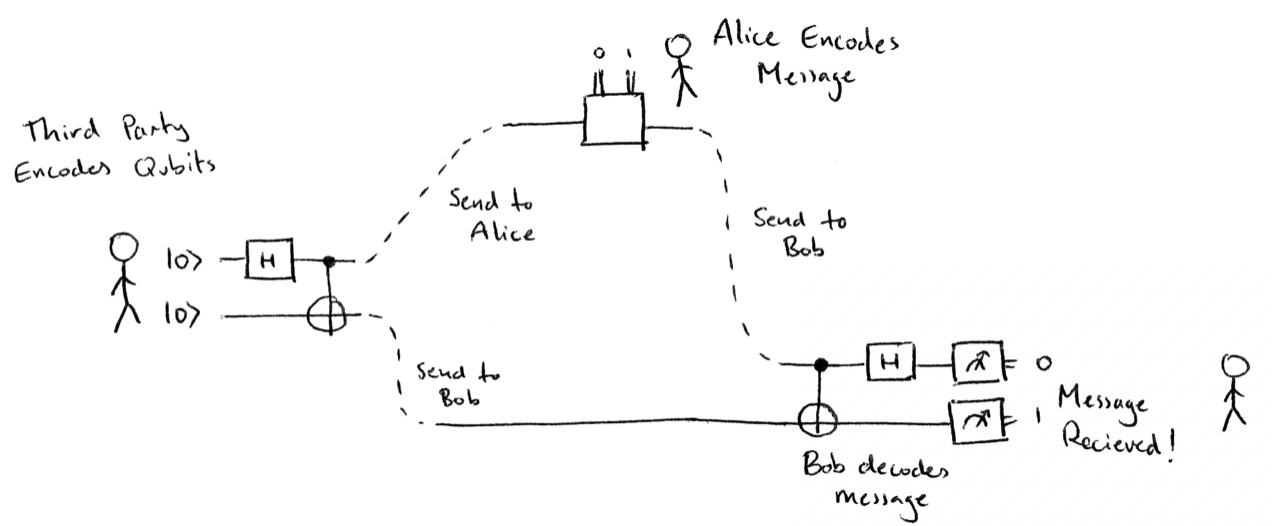

### 2.1 Step 1

プロセスは、チャーリーと呼ぶサードパーティから始まります。2つのqubitが絡み合った状態でチャーリーによって準備されます。彼は最初に2つのqubitを基底状態|0>で開始します。彼はアダマールゲート(H)を最初のqubitに適用して、重ね合わせを作成します。次に、最初のqubitをコントロールとして使用し、2番目のqubitをターゲットとして使用して、CNOTゲート(CX)を適用します。これは、前述の絡み合った状態(ベルペア)です。

#### Outcome States

チャーリーは最初にアダマールゲートを適用します。

Hゲートが最初のqubitに適用されると、重ね合わせが作成され、状態が取得されます。

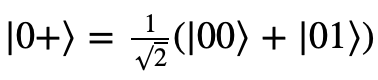

次に、チャーリーはCNOTゲートを適用します。CNOTゲートは両方のqubitを絡ませます。つまり、コントロールが|1>の場合、ターゲットが反転します。制御qubitが右端のqubitであることに注意してください。

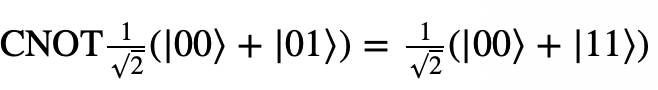

### 2.2 Step 2

#### Encoding  Rules for Suuperdense Condig(Alice protocol)

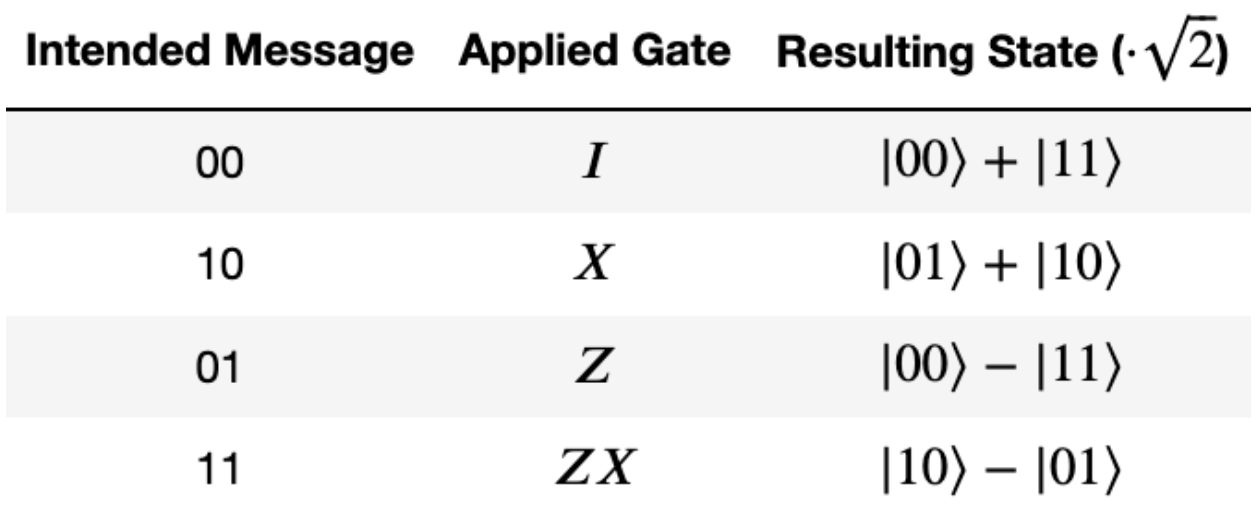

従って、彼女が00を送信したい場合、彼女はqubitに対して何もしません(identity(I)ゲートを適用します)。彼女が10を送信すると、Xゲートが適用されます。送信したい内容に応じて、適切なゲートを適用し、qubitをボブに送信して、プロセスの最後のステップに進みます。

### 2.3 Step 3

ボブはアリスのqubit(右端のqubit)を受け取り、そのqubitを使用してアリスのメッセージをデコードします。彼はそれをデコードするために状態の知識を持つ必要がないことに注意してください。彼は単に復元操作を使用します。

ボブは、右端のqubitをコントロールとして使用し、左端をターゲットとして使用してCNOTゲートを適用します。次に、アダマールゲートを適用し、最後に両方のqubitで測定を実行して、アリスのメッセージを抽出します。

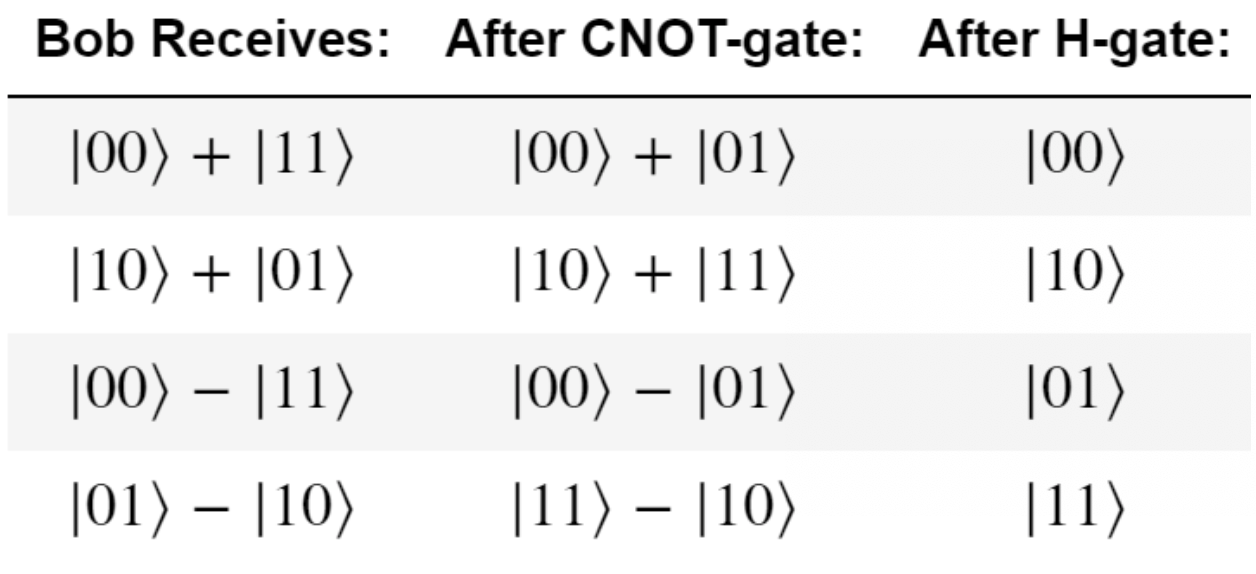

ボブが測定を実行するとき、アリスが彼に送信したメッセージを確実に受信します。最後の結果には負の符号-|11>があることに注意してください。|11>と書くことも、これはグローバルフェーズであり、測定できないため、正しいです。

## 3. Simulating the  Superdense Coding Protocol

In [1]:
# Importing everything
from qiskit import *
from qiskit.visualization import plot_histogram
# For Jupyter Notebooks, change the settings to get nicer images
%config InlineBackend.figure_format = 'svg'

絡み合わさったペアを作成するには、Hゲートの後にCNOTを実行する必要があることがわかりました。量子回路を取り、インデックスaとbでqubitをもつれさせる関数を作成しましょう。

In [2]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b)
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

次に、メッセージをエンコードする必要があります。送信できるメッセージは4つあります。00、01、10または11です。このメッセージを受け取り、適切なゲートを適用する関数を作成してみましょう。

In [3]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

最後に、メッセージをデコードする必要があります。これは、Hゲートが後に続くCNOTを使用して実行できることがわかりました。これを行う関数も作成してみましょう。

In [4]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

最後に、これを組み合わせてプロトコルを完成させることができます。

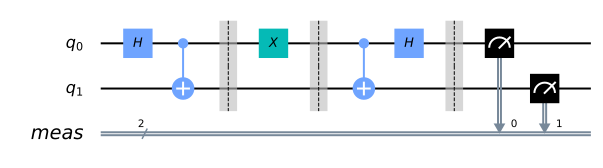

In [5]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw(output = "mpl")

###  3.1 Visualizinng Our Measurements

{'10': 1024}


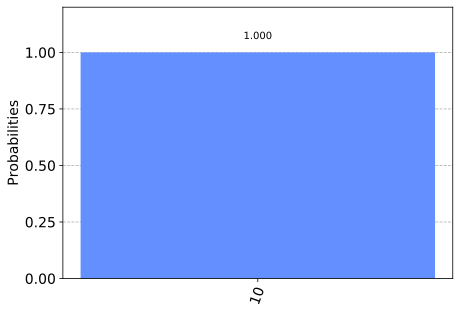

In [6]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

私たちのシミュレーターは完全な量子コンピュータをシミュレートします。エラーなしで、正しいメッセージを測定する確率が100%であることがわかります。

## 4. Superdense Coding on a Real Quantum Computer

これが実際の量子コンピュータで機能しているのがわかります。最初に、最も負荷の少ない量子システムを取得するためにアカウントをロードします。

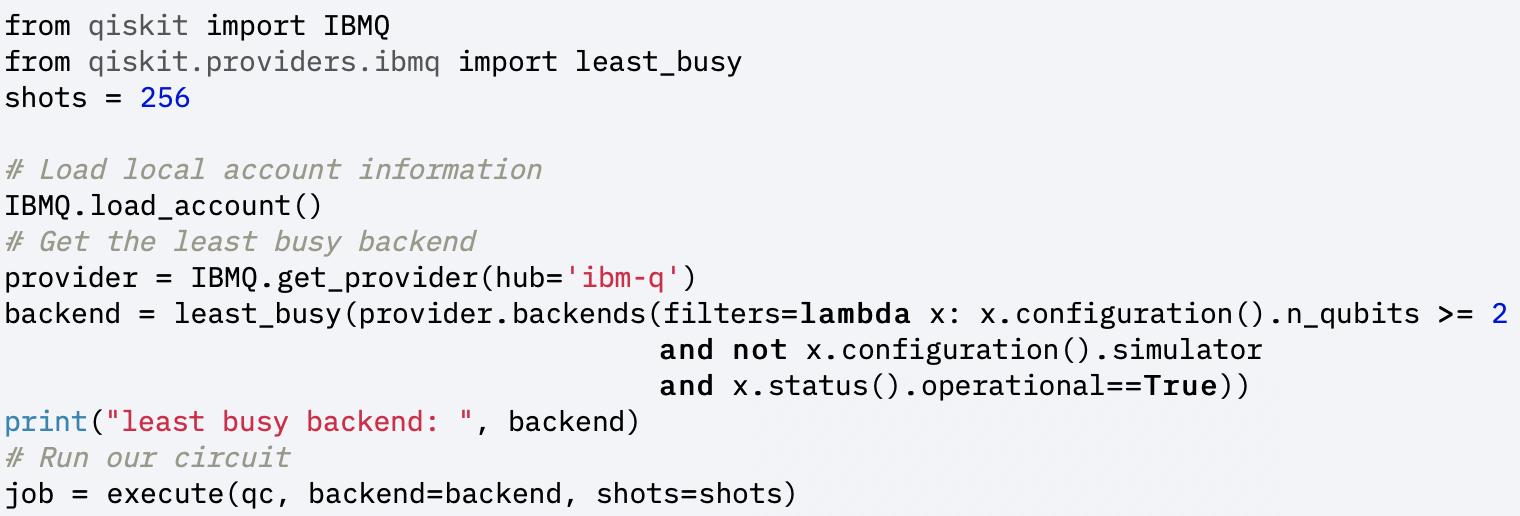

least busy backend:  ibmq_ourense

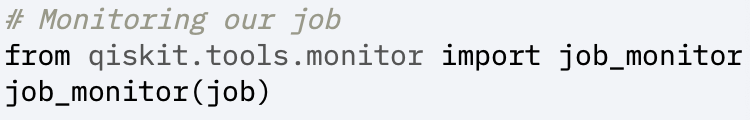

Job Status: job has successfully run

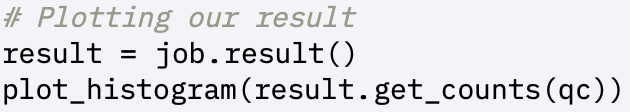

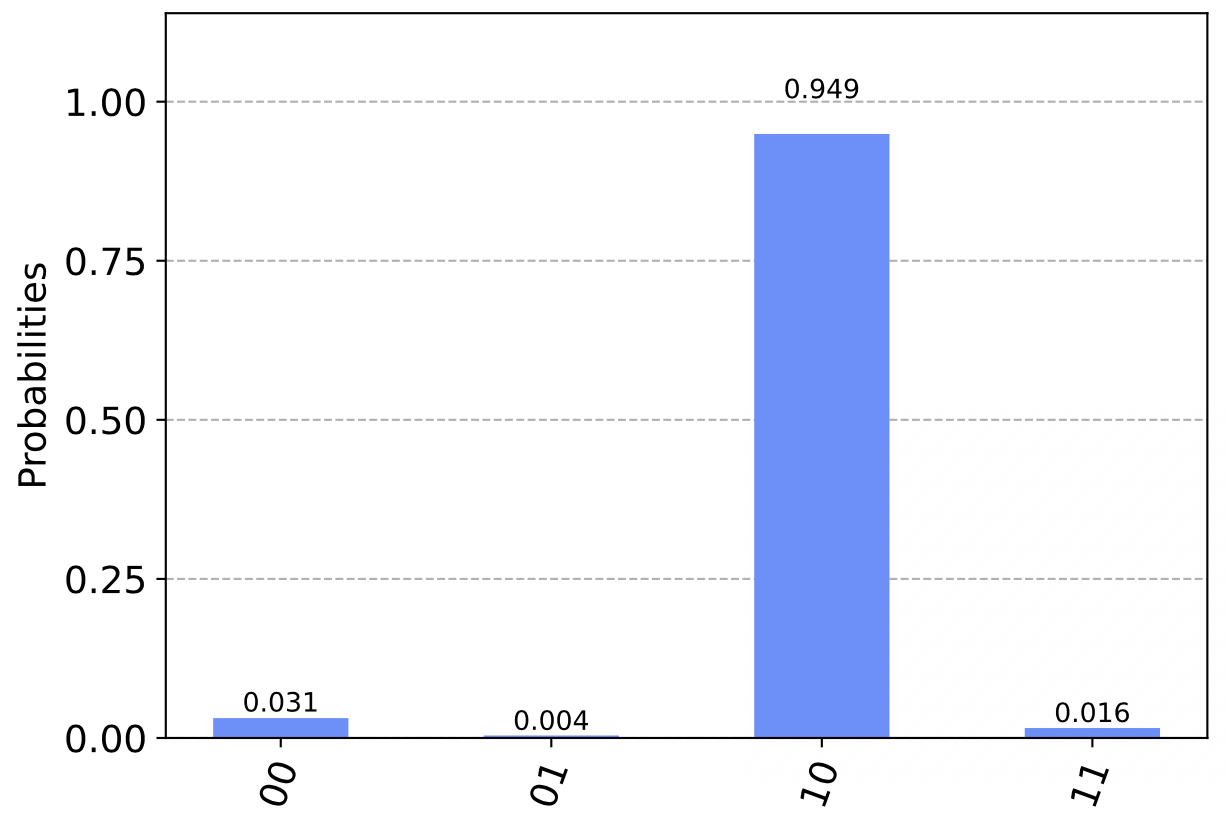

実際の量子コンピュータで実行すると、他の3つの状態からいくつかの結果があることがわかります。これらは、ゲートのエラーとqubitデコヒーレンスが原因です。これらのエラーについては、後のセクションで詳しく説明します。

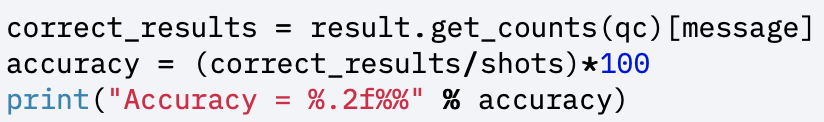

Accuracy = 94.92%